# Evaluación de la pérdida de calidad del audio usando el codec OPUS

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 5 min read

---

## Resumen

La comunicación en la actualidad sería impensable sin el uso de codecs de audio digital para reducir el consumo del ancho de banda en las transmisiones de voz y música. Estos codecs utilizan algoritmos de compresión y limpieza del ruido para eliminar información del audio que el oído humano no escucha tan bien, para ello se utiliza un concepto llamado _bandas críticas_  y escala Bark (frecuencias bajas tienen mayor resolución que frecuencias bajas). Sin embargo, esta habilidad de compresión es precisamente una limitante para los sistemas de telemedicina que usan estetoscópios digitales, pues estos requieren analizar el audio sin pérdida de información. En este ipython notebook estudiamos la pérdida de la calidad del audio producida por el codec OPUS al analizar sonidos producidos por el corazón o los pulmones. Los resultados están aún por determinarse...

# 1 Códec OPUS

Código abierto, frecuencia de muestreo de 8kHz a 48kHz, soporta voz y música [3]... Alternable entre SILK, CELT e híbrido [3].

* SILK para voz, códec creado por Skype Limited open-source y freeware basado en Codificación de Predicción Lineal [4, 5]. 
* Constrained Energy Lapped Transform (CELT) para música y voz de alta calidad, tomado de Ogg  
* E híbrido ...

Transformada Discreta del Coseno Modificada (MDCT) y escala similar a Bark para enmascaramiento y preservación de la envolvente espectral. Ventana de análisis similar a la Hann o Hamming [3]...

* Enmascaramiento frecuencial
<img src='img/QA_2-0112.jpeg' width='40%'>
Figura 1. Tomada de https://output.com/blog/9-sound-design-tips-to-hack-your-listeners-ears.

* Enmascaramiento temporal
<img src='img/3-Figure2-1.png' width=40%>
Figura 2. Tomada de https://d3i71xaburhd42.cloudfront.net/13674722d0e4fc8a6877773b25a62ee9850eb46a/3-Figure2-1.png.

* Escala Bark

Alta calidad desde el bitrate 8 kHz hasta 128 kHz [3]...

<img src='img/qualityOpus.png' width='50%'>
Figura 1. Tomada de https://opus-codec.org/static/comparison/quality.svg.


# 2 Casos de prueba

Las mismas virtudes que hacen al algoritmo OPUS guardar espacio sin sacrificar la calidad del audio percibido por el oido humano pueden afectar la eficacia de un algoritmo de clasificación de patrones:

1. Al procesar dos tonos cercanos en frecuencia, el tono de energía más alta no debe enmascarar al de frecuencias más baja (enmascariento frecuencial).
2. Al procesar dos tonos cercanos en tiempo, el tono de energía más alta no debe enmascarar al de energía más baja (enmascariento temporal).
3. En general, el contenido de la magnitud espectral presente en un barrido de frecuencias debe mantenerse, sin que se agreguen o eliminen frecuencias.

## 2.1 Barrido de frecuencias

Para evaluar la distorción producida por el códec Opus, podemos usar un barrido de frecuencia de la forma [6]:
$$
F(t) = \Big(\frac{F_1-F_0}{T}\Big)t + F_0,
$$

para determinar cuales frecuencias han sido perdidas después del procesamiento. El rango de frecuencias a usar puede ser $[20, 22.5K]$ Hz (el rango conseguido comunmente con los equipos electrónicos comerciales). El barrido puede ser construido usando un senoidal de la forma $x[t] = A \sin(2\pi Ft)$.

Como el enmascaramiento frecuencial funciona para frecuencias cercanas, agregamos un tono adicional en la forma:

$$
x[t] = \sin(2\pi F_0 t) + \sin(2\pi 1.1 F_0 t).
$$

Populating the interactive namespace from numpy and matplotlib


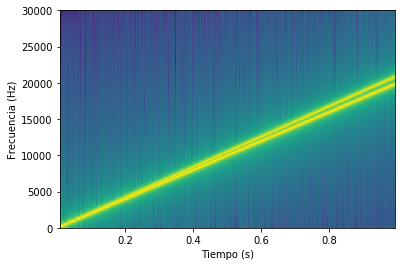

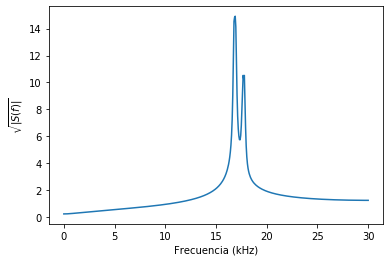

In [43]:
%pylab inline
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np

def plotSpecgram(x,fs):
    # specgram
    fig, ax = pylab.subplots(nrows=1)
    ax.specgram(x, NFFT=1024, Fs=Fs, noverlap=900)
    pylab.xlabel('Tiempo (s)')
    pylab.ylabel('Frecuencia (Hz)')
    pylab.show()
    
def plotFFT(x,fs):
    pylab.figure()
    N2=int(len(x)/2)
    f = np.linspace(0,fs/2,N2)/1000
    X = np.sqrt(np.abs(np.fft.fft(x)[0:N2]))
    pylab.plot(f, X)
    X[0] = 0 # remove DC value
    pylab.xlabel('Frecuencia (kHz)')
    pylab.ylabel('$\sqrt{|S(f)|}$')
    pylab.show()

rango = [20.0, 20000.0] # el rango promedio de audicion humano en Hz
Fs = rango[1]*3 # 2 veces la freq. maxima para cumplir con el teorema del muestreo
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
x = np.sin(np.pi*F0/Fs*n) + 0.5*np.sin(np.pi*1.05*F0/Fs*n) # f=F0/Fs (discrete frequency)

plotSpecgram(x,Fs)
plotFFT(x[50000:51000],Fs)

wavfile.write('/tmp/barrido_20_20k.wav',int(Fs),x)
Audio(x, rate=Fs) 

Se observan dos rectas correspondientes a los barridos de frecuencia en $F_0$ y $1.1 F_0$, y el resto del espectro está limpio. Se comprueba con la FFT que todas las frecuencias del barrido están presentes, como se esperaba.

# 2.2 Ejecución de los casos de prueba

Ahora, realizamos el procesamiento con Opus usando, 8 Kbps, la tasa de bits narroband en la figura 1 que tambien corresponde a la calidad de una video llamada 1:1 segun https://www.reviews.org/internet-service/how-much-data-does-zoom-use/:

Skipping chunk of type "LIST", length 26


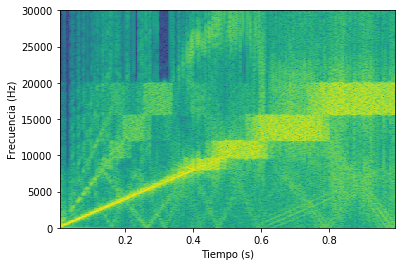

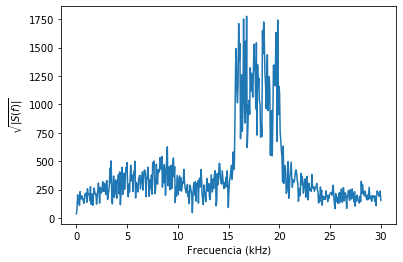

In [44]:
def readPlayVisualizeFile(inputFile):
    fs, x = wavfile.read(inputFile)
    y = np.array(x)/max(x)
    plotSpecgram(x,fs)
    return fs, x

!sudo apt-get install opus-tools
!ffmpeg -loglevel error -y -i /tmp/barrido_20_20k.wav -qscale 0 /tmp/wavRaw.wav # same quality
!opusenc --quiet --bitrate 16 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav
fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x[50000:51000],Fs)

Audio(x, rate=fs)

**Nota:** use audifonos para apreciar mejor la calidad el audio.

Como se observa, las frecuencias más altas que 5K Hz fueron truncadas completamente. Probemos ahora con 128 kbps (fullband stereo) a ver si la calidad mejora.

Skipping chunk of type "LIST", length 26


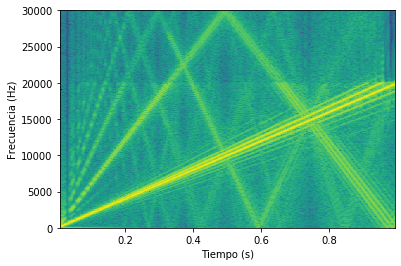

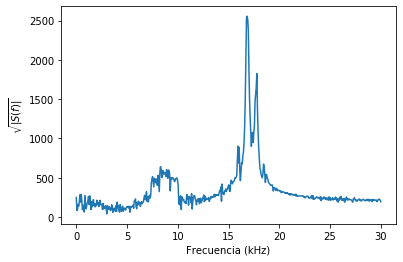

In [45]:
!ffmpeg -loglevel error -y -i /tmp/barrido_20_20k.wav -qscale 0 /tmp/wavRaw.wav # same quality
!opusenc --quiet --bitrate 128 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav
fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x[50000:51000],Fs)

Audio(x, rate=fs)

Observamos que el contenido frecuencial ha sufrido muchos cambios, entre ellos, se introdujeron frecuencias parásitas producto del aliasing, hay al menos 4 rectas principales en lugar de 2, también parece que se ha aplicado un filtro pasabajas con frecuencia de corte 20K Hz. Entonces sí que el codec Opus introduce distorsiones. Esto significa que si se aplica reconocimiento de patrones a una grabación procesada por Opus, el clasificador tendría información con mucho más ruido que con una grabación en formato WAV. 

# 3 Analizando una grabación real

Ahora realicemos una prueba procesando una grabación empleada en el reconocimiento de sonidos del cuerpo (una disciplina llamada auscultación). Para tomamos una grabación del sitio https://www.kaggle.com/vbookshelf/respiratory-sound-database. 

<Figure size 432x288 with 0 Axes>

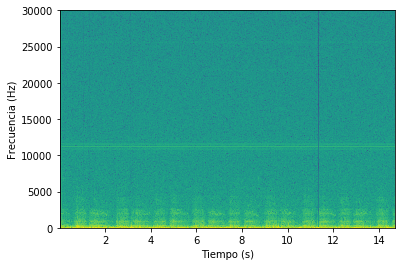

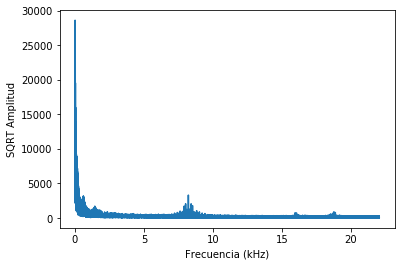

In [126]:
fs, x = readPlayVisualizeFile('./wav/107_3p2_Tc_mc_AKGC417L_2.wav')
plotFFT(x,fs)

Audio(x, rate=fs)

Observamos que hay energía alta en el rango $[0,1.5]$ y $[7.5,9.5]$ kHz.

Skipping chunk of type "LIST", length 26


<Figure size 432x288 with 0 Axes>

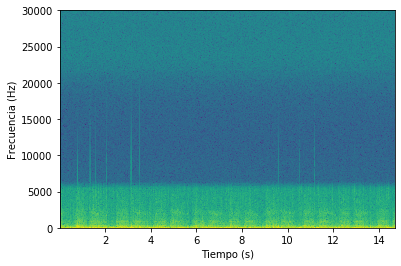

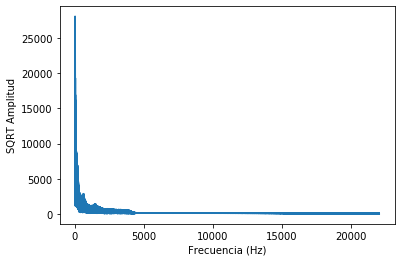

In [123]:
!ffmpeg -loglevel error -y -i ./wav/107_3p2_Tc_mc_AKGC417L_2.wav -qscale 0 /tmp/wavRaw.wav # same quality
!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav
fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,fs)

Audio(x, rate=fs)

Al parecer, la cantidad de bits usados tiene un efecto directamente proporcional sobre la frecuencia de corte. Además, observamos que la energía del rango $[0,1.5]$ se dispersó ahora por $[0,4.5]$ kHz y que el pic en $[7.5,9.5]$ kHz desapareció.

# 4 Conclusiones

Lorem ipsum...


# Referencias
1. Colaboradores de Wikipedia. Códec de audio [en línea]. Wikipedia, La enciclopedia libre, 2020 [fecha de consulta: 4 de noviembre del 2020]. Disponible en <https://es.wikipedia.org/w/index.php?title=C%C3%B3dec_de_audio&oldid=129362034>. 
2. Hong  Kong  Polytechnic  University. Department of Electronic and Information Engineering. Perceptual Coding and MP3. Disponible en <http://www.eie.polyu.edu.hk/~enyhchan/DAP-lab-PModel-v3.pdf>.
3. López Monfort José Javier. Opus codec | 22/23 | UPV. Universitat Politècnica de València - UPV. Disponible en <https://youtu.be/2-yv1bCDL94>. 
4. Wikipedia contributors. (2020, October 11). SILK. In Wikipedia, The Free Encyclopedia. Retrieved 15:18, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=SILK&oldid=982904860
5. Wikipedia contributors. (2020, November 2). Linear predictive coding. In Wikipedia, The Free Encyclopedia. Retrieved 15:22, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=Linear_predictive_coding&oldid=986664067
6. EPFL. Room impulse responses. Ultima vez consultado el 27 Dec 2020 en: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = { Pruebas por pares o pairwise testing},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.pairwisetesting.html},
  urldate = {}
}
```